In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import re

# Loading data

Data can be downloaded as a `zip` file at https://drive.google.com/file/d/1h0ThrK252cyeJr4TwkqQCNKJhGMji-4B/view?usp=sharing

It contains the following files:

- `newspapers.jsonl` 190MB, 100 000 articles
- `newspapers_sample.jsonl` 200KB, 100 articles

Extract them to the project's root directory.

JSONL is a file format that contains a sequence of JSON objects, each object in a separate line.


In [2]:
from json import loads, dumps

data_sample = [
    loads(line)
    for line in open("data/newspapers_sample.jsonl", "r", encoding="utf-8").readlines()
]

data = [
    loads(line)
    for line in open("data/newspapers.jsonl", "r", encoding="utf-8").readlines()
]

data_sample[:3]

[{'text': 'On ne s’attendait pas du tout à trouver une ville aussi jolie entourée de remparts. » La surprise émerveille plus d’un touriste, qu’il soit français ou étranger, quand il découvre Angoulême. Le Plateau et ses ruelles surprennent. Et surtout séduisent. Notamment les étrangers dont on fête le grand retour, cette année, après deux étés de disette en raison de la crise sanitaire.\n\nBelges, Britanniques et Néerlandais constituent le hit de parade des nationalités représentées depuis début juillet. On croise également des Espagnols, des Italiens et quelques Nord-Américains. Et même des Danois, accueillis pour la première fois au Musée d’art et d’histoire de la ville. « Peut-être grâce au Tour de France ! », avance-t-on dans un sourire à l’accueil.\n\nLes Anglo-Saxons et les vieilles pierres\n\nDifficile de dire si le label « Ville créative », délivré par l’Unesco fin 2019, pèse sur la venue d’étrangers dans la ville. Peu semblent au courant de cette reconnaissance. S’ils s’arrête

### Fields

What are the fields of the JSON objects?


In [3]:
keys = {key for item in data for key in item.keys()}
keys

{'article', 'date', 'text', 'title'}

### Transform the json objects in dataframes


In [4]:
df = pd.DataFrame(data)
df_sample = pd.DataFrame(data_sample)

In [5]:
df["date"]

0        2022-03-07T00:00:00.000
1        2023-11-26T00:00:00.000
2        2023-09-06T00:00:00.000
3        2022-11-09T00:00:00.000
4        2022-03-11T00:00:00.000
                  ...           
99995    2022-07-04T00:00:00.000
99996    2022-11-29T00:00:00.000
99997    2023-02-21T00:00:00.000
99998    2022-08-29T00:00:00.000
99999    2022-03-10T00:00:00.000
Name: date, Length: 100000, dtype: object

### Trim text fields

In [6]:
df["title"] = df["title"].apply(lambda x: x.strip())
df['text'] = df['text'].apply(lambda x: x.strip())

### Parse dates


In [7]:
### Parse dates

df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%dT%H:%M:%S.%f")

### Any missing values? (No)


In [8]:
df.isnull().sum()

text       0
title      0
date       0
article    0
dtype: int64

# Lengths of titles and texts


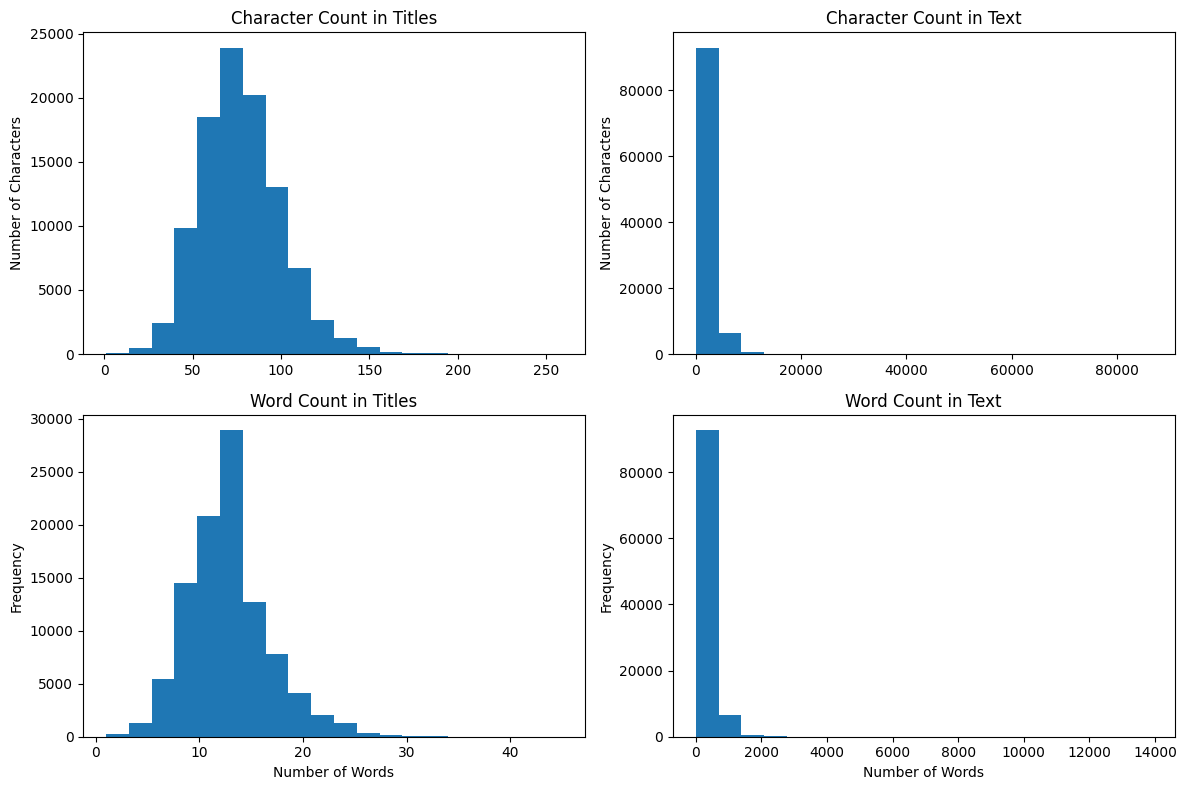

In [9]:
# Calculate the number of characters in titles and text
df["title_char_count"] = df["title"].str.len()
df["text_char_count"] = df["text"].str.len()

# Calculate the number of words in titles and text
df["title_word_count"] = df["title"].str.split().str.len()
df["text_word_count"] = df["text"].str.split().str.len()

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Boxplot of character count in titles
axs[0, 0].hist(df["title_char_count"], bins=20)
axs[0, 0].set_title("Character Count in Titles")
axs[0, 0].set_ylabel("Number of Characters")

# Boxplot of character count in text
axs[0, 1].hist(df["text_char_count"], bins=20)
axs[0, 1].set_title("Character Count in Text")
axs[0, 1].set_ylabel("Number of Characters")

# Histogram of word count in titles
axs[1, 0].hist(df["title_word_count"], bins=20)
axs[1, 0].set_title("Word Count in Titles")
axs[1, 0].set_xlabel("Number of Words")
axs[1, 0].set_ylabel("Frequency")

# Histogram of word count in text
axs[1, 1].hist(df["text_word_count"], bins=20)
axs[1, 1].set_title("Word Count in Text")
axs[1, 1].set_xlabel("Number of Words")
axs[1, 1].set_ylabel("Frequency")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [10]:
# Show the longuest titles
longuest_titles = df.sort_values("title_char_count", ascending=False).head(200)

longuest_titles[["title", "title_char_count"]]

,title,title_char_count
42978,L'essentiel du sport dans nos régions. Antoine...,259
48421,En image | ddddddddddddddddddddddddddddddddddd...,249
28621,"La Suédoise Linn Grant regarde son drive, au d...",248
91553,La Matinale. Pierre Palmade gravement blessé d...,245
27317,L'essentiel du sport dans nos régions. Premier...,238
...,...,...
99320,Des naturalistes d'Alsace Bossue mobilisés con...,165
11647,Mâcon (communiqué ). La commission des finance...,165
77353,"Disparition d'Alex Batty : ""Il nous accompagna...",165
16987,Un 47eme fourgon d'intervention percuté sur l'...,165


### Repeating characters


- We found the text `dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddeeeeeeeeeeeeeeeeeeeePose`in a title.
  It might be useful to count the number of repeating characters in the text.


In [11]:
def count_repeating_chars(text: str) -> int:
    """Count the number of repeating characters in a string.

    Example:
    count_repeating_chars('aab') -> 1
    count_repeating_chars('aaabb') -> 3
    """
    count = 0
    for i in range(1, len(text)):
        if text[i] == text[i - 1]:
            count += 1
    return count


assert count_repeating_chars("aab") == 1
assert count_repeating_chars("aaabb") == 3

In [12]:
def count_repeating_non_whitespace_chars(text: str) -> int:
    """Count the number of repeating non-whitespace characters in a string.

    Example:
    count_repeating_non_whitespace_chars('aab') -> 1
    count_repeating_non_whitespace_chars('aaabb') -> 3
    count_repeating_non_whitespace_chars('aa a') -> 2
    """
    text = text.replace(" ", "").replace("\n", "").replace("\t", "").replace("\r", "")
    return count_repeating_chars(text)


assert count_repeating_non_whitespace_chars("aab") == 1
assert count_repeating_non_whitespace_chars("aaabb") == 3
assert count_repeating_non_whitespace_chars("aa a") == 2

Only counting the number of repeating characters in the text would penalize long texts. We should normalize this number by the length of the text.


In [13]:
# Count repeating characters in titles and text and dividing by the number of characters

df["title_repeating_chars"] = (
    df["title"].apply(count_repeating_non_whitespace_chars) / df["title_char_count"]
)
df["text_repeating_chars"] = (
    df["text"].apply(count_repeating_non_whitespace_chars) / df["text_char_count"]
)

In [14]:
# Show the rows with the highest ratio of repeating characters in titles
df.sort_values("title_repeating_chars", ascending=False).head(10)[
    ["title", "title_repeating_chars"]
]

,title,title_repeating_chars
48421,En image | ddddddddddddddddddddddddddddddddddd...,0.510040
34828,ZOOM,0.250000
16286,495 000 €,0.222222
9521,XXXXXXXXX. Une législation qui évolue en perma...,0.176471
22558,500 à sillonner le terroir,0.153846
73655,Comment placer 50 000 euros,0.148148
82484,Halloween en familles,0.142857
12681,Football. ASSE : le successeur de Laurent Batl...,0.121212
63319,On a testé...l'attelage !,0.120000
52597,Un football lorrain au fort accent polonais,0.116279


In [15]:
# Same for text
df.sort_values("text_repeating_chars", ascending=False).head(10)[
    ["title", "text", "text_repeating_chars"]
]

,title,text,text_repeating_chars
48421,En image | ddddddddddddddddddddddddddddddddddd...,En image | ddddddddddddddddddddddddddddddddddd...,0.414791
56337,Confolens : Le prix Abel Desaphy disputé jeudi,"Pour les épreuves d’école de vélo, les dossard...",0.314079
92943,Football : découvrez les affiches du 5e tour d...,????? ?? ?????? : ???????? ?? ?? ???? \ud83c\u...,0.235808
26287,Aveyron : suivez le week-end de sports en direct,"Football, basket-ball, handball, moto ou encor...",0.205108
73389,"Football, basket-ball, handball : suivez les r...",Suivez ci-dessous l'avancée des résultats spor...,0.175405
27180,"Football, handball, trail : retrouvez tous les...",Retrouvez ci-dessous l'ensemble des résultats ...,0.135633
95416,"Rugby, football, basket-ball : suivez en direc...","Football, rugby à XIII et à XV, handball, bask...",0.119357
64024,"Football, auto, basket-ball : suivez en direct...","Football, rugby à XIII, handball, automobile.....",0.101159
55529,"Basket-ball, rugby, football : découvrez tous ...","Basket-ball, football, handball, rugby....Retr...",0.100370
81783,"Football, basket-ball, rugby : le Sporting dec...","Football, rugby à XIII et à XV, handball, cour...",0.093532


Turns out the only problematic text is the one mentioned above.


In [16]:
# Drops rows having a title with more than 0.50 repeating characters score
df = df[df["title_repeating_chars"] < 0.50]

### Looking at the shortests titles


In [17]:
df.sort_values("title_char_count").head(10)[["title", "title_char_count", "text"]]

,title,title_char_count,text
59191,8,1,"...pour lire la suite, rejoignez notre communa..."
85033,164,3,"164\n\nC’est en millions d’euros, la somme des..."
43755,"3,38",4,"en millions d’euros, c’est le montant de l’env..."
34828,ZOOM,4,ZOOM\n\nPar Le Progrès - Hier à 18:37 - Temps ...
62470,L'Ouïe,6,Entendre c’est aussi se donner le temps d’appr...
87771,Vite lu,7,Arbres abattus avenue du 8-Mai-1945. Les agent...
92692,➤ Voir,7,➤ Voir\n\nPar Le Bien Public - Aujourd'hui à 1...
49896,Vite lu,7,Concert avec dimanche avec Franck Besingrand. ...
2078,Repères,7,Repères\n\nPar Le Dauphiné Libéré - Aujourd'hu...
6891,contexte,8,"...pour lire la suite, rejoignez notre communa..."


Let's find titles which only consists of numbers and special characters


In [18]:
import string

FRENCH_LETTERS = string.ascii_letters + "àâçéèêëîïôûüÿæœ"
FRENCH_LETTERS

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZàâçéèêëîïôûüÿæœ'

In [19]:
def get_only_alpha_text(text: str, alphabset_set=FRENCH_LETTERS) -> str:
    """Return a string containing only the letters of the input string.

    Example:
    get_only_alpha_text("Hello, world 23,1!") -> "Helloworld"
    """
    return "".join([c for c in text if c in alphabset_set])


assert get_only_alpha_text("Hello, world 23,1!") == "Helloworld"

In [20]:
# Create a new column with only the letters of the title

df["title_alpha"] = df["title"].apply(get_only_alpha_text)

# Create a new column with the number of chars in title_alpha

df["title_alpha_char_count"] = df["title_alpha"].str.len()

# Show the rows with the shortest title_alpha
df.sort_values("title_alpha_char_count").head(100)[
    ["title", "title_alpha", "title_alpha_char_count"]
]

,title,title_alpha,title_alpha_char_count
16286,495 000 €,,0
43755,"3,38",,0
59191,8,,0
85033,164,,0
34828,ZOOM,ZOOM,4
...,...,...,...
17074,SAVOIE. État civil,SAVOIEtatcivil,14
47951,SAVOIE. État civil,SAVOIEtatcivil,14
89156,Moselle. Et aussi…,MoselleEtaussi,14
16206,SAVOIE. État civil,SAVOIEtatcivil,14


We remove the rows having titles with less than 10 alpha characters


In [21]:
# We remove the rows having titles with less than 10 alpha characters
before_len = len(df)
df = df[df["title_alpha_char_count"] >= 10]
after_len = len(df)

print(f"Removed {before_len - after_len} rows")

Removed 37 rows


In [22]:
### Removing arrows from titles

df['title'] = df['title'].str.replace("➤", "",regex=False)


# Url


### Extract URL


In [23]:
import validators
from typing import Tuple, Optional

Url = str


def extract_id_and_url(article: str) -> Tuple[Optional[str], Optional[Url]]:
    if " at " in article:
        id, url = article.split(" at ")
        assert validators.url(url)
        return id, url

    url = article.strip("tag:")
    if not validators.url(article):
        return None, None

    return None, url


assert extract_id_and_url(
    "2047761 at https://france3-regions.francetvinfo.fr/occitanie"
) == ("2047761", "https://france3-regions.francetvinfo.fr/occitanie")
assert extract_id_and_url("https://france3-regions.francetvinfo.fr/occitanie") == (
    None,
    "https://france3-regions.francetvinfo.fr/occitanie",
)

df["article_id"], df["article_url"] = zip(*df["article"].apply(extract_id_and_url))

df.head()

,text,title,date,article,title_char_count,text_char_count,title_word_count,text_word_count,title_repeating_chars,text_repeating_chars,title_alpha,title_alpha_char_count,article_id,article_url
0,"L'international de pétanque de Sète, avait lie...","International de Sète : la pétanque, une affai...",2022-03-07,2047761 at https://france3-regions.francetvinf...,74,2397,13,411,0.027027,0.026283,InternationaldeSètelapétanqueuneaffairedefamil...,60,2047761,https://france3-regions.francetvinfo.fr/occitanie
1,Ce contenu est bloqué car vous n'avez pas acce...,Massif des Vosges. La route des Crêtes fermée ...,2023-11-26,https://www.vosgesmatin.fr/environnement/2023/...,70,594,13,95,0.014286,0.026936,MassifdesVosgesLaroutedesCrêtesferméeàpartirdu...,56,None,https://www.vosgesmatin.fr/environnement/2023/...
2,Le tribunal de commerce de Chambéry va connaît...,Savoie. Discrimination raciale: quatre chauffe...,2023-09-06,https://www.ledauphine.com/faits-divers-justic...,102,397,13,64,0.019608,0.027708,SavoieDiscriminationracialequatrechauffeurspor...,88,None,https://www.ledauphine.com/faits-divers-justic...
3,La 38e campagne d’hiver de l’association comme...,"TÉMOIGNAGE. Les Restos du Coeur recrutent : ""o...",2022-11-09,2651444 at https://france3-regions.francetvinf...,97,4721,17,793,0.030928,0.026477,TMOIGNAGELesRestosduCoeurrecrutentonestnourrid...,75,2651444,https://france3-regions.francetvinfo.fr/occita...
4,Sur le même sujet Dordogne : contre le cancer ...,"Mars bleu, pour favoriser le dépistage du canc...",2022-03-11,https://www.sudouest.fr/dordogne/thiviers/mars...,77,853,12,131,0.000000,0.017585,Marsbleupourfavoriserledépistageducancercolore...,64,None,https://www.sudouest.fr/dordogne/thiviers/mars...


In [24]:
### Extract the domain name from the URL

from urllib.parse import urlparse


def extract_domain(url: Url) -> str:
    return urlparse(str(url)).netloc.strip(".www")


assert (
    extract_domain("https://france3-regions.francetvinfo.fr/occitanie")
    == "france3-regions.francetvinfo.fr"
)

df["article_domain"] = df["article_url"].apply(extract_domain)
df.head(3)

,text,title,date,article,title_char_count,text_char_count,title_word_count,text_word_count,title_repeating_chars,text_repeating_chars,title_alpha,title_alpha_char_count,article_id,article_url,article_domain
0,"L'international de pétanque de Sète, avait lie...","International de Sète : la pétanque, une affai...",2022-03-07,2047761 at https://france3-regions.francetvinf...,74,2397,13,411,0.027027,0.026283,InternationaldeSètelapétanqueuneaffairedefamil...,60,2047761,https://france3-regions.francetvinfo.fr/occitanie,france3-regions.francetvinfo.fr
1,Ce contenu est bloqué car vous n'avez pas acce...,Massif des Vosges. La route des Crêtes fermée ...,2023-11-26,https://www.vosgesmatin.fr/environnement/2023/...,70,594,13,95,0.014286,0.026936,MassifdesVosgesLaroutedesCrêtesferméeàpartirdu...,56,None,https://www.vosgesmatin.fr/environnement/2023/...,vosgesmatin.fr
2,Le tribunal de commerce de Chambéry va connaît...,Savoie. Discrimination raciale: quatre chauffe...,2023-09-06,https://www.ledauphine.com/faits-divers-justic...,102,397,13,64,0.019608,0.027708,SavoieDiscriminationracialequatrechauffeurspor...,88,None,https://www.ledauphine.com/faits-divers-justic...,ledauphine.com


# Removing cookies banners, paywalls, and other non-content text


### "Pour lire la suite"


In [25]:
# We want to know what's after "pour lire la suite". We will extract the next 20 characters after the match, put them in a set, and display the set.
# This will give us an idea of the different ways this sentence is completed.

pour_lire_la_suite = df["text"].str.contains("pour lire la suite", case=False)

df[pour_lire_la_suite]["text"].str.extract(
    r"pour lire la suite(.{20})", flags=re.IGNORECASE
)[0].unique()

array([', rejoignez notre co', ', abonnez-vous : Déc',
       ', abonnez-vous : Dec', ' de cet article et a'], dtype=object)

When "Pour lire la suite" appears in the text, it's always followed by

- `, rejoignez notre communauté`
- `, abonnez-vous`
- ` de cet article`

So the text "Pour lire la suite" is never a part of the article. We can safely characterize them as "paywall"


In [26]:
# mark the rows where the text contains "pour lire la suite"
# For all rows of `pour_lire_la_suite`, mark the "content_restrictions" column as "paywall"

df.loc[pour_lire_la_suite, "content_restrictions"] = "paywall"

print(f"Marked {pour_lire_la_suite.sum()} rows as paywall")

Marked 6058 rows as paywall


### Other restrictions


In [27]:
COOKIE_WALL_TRIGGER = [
    "Ce contenu est bloqué car vous n'avez pas accepté les cookies.",
    "Ce contenu est bloqué car vous n'avez pas accepté les traceurs",
    "En cliquant sur « J’accepte tous les cookies »",
    "Deconnectez-vous systematiquement avant de fermer la fenetre du navigateur",
    "Déconnectez-vous systématiquement avant de fermer la fenêtre du navigateur",
    "En acceptant les cookies, vous pourrez accéder aux contenus et fonctionnalités gratuites que propose notre site.",
    "but your activity and behavior on this site made us think that you are a bot",
"Nous utilisons des cookies ou technologies",
"Ce contenu est bloque car",
"Si vous souhaitez modifier vos centres d'intérêt, vous pouvez à tout moment cliquer sur le lien",
]

cookies = df["text"].str.contains("|".join(COOKIE_WALL_TRIGGER), case=False)

df.loc[cookies, "content_restrictions"] = "cookie-wall"

print(f"Marked {cookies.sum()} rows as cookie-wall")

Marked 6328 rows as cookie-wall


In [28]:
PAYWALL_TRIGGER = [
    "Cet article est réservé aux abonnés.",
    "Abonnez-vous pour 1€ Accédez en illimité à tous les dossiers",
    "Abonnez-vous pour 1€",
    "Réservé aux abonnés",
    "En cliquant sur « je m’abonne »",
]


paywall = df["text"].str.contains("|".join(PAYWALL_TRIGGER), case=False)


df.loc[paywall, "content_restrictions"] = "paywall"

print(f"Marked {paywall.sum()} rows as paywall")

Marked 841 rows as paywall


In [29]:
PODCAST_TRIGGER = [
    "Écoutez cet épisode et abonnez-vous",
    "Ecoutez cet épisode et abonnez-vous",
    "sur votre plateforme audio favorite",
]

podcast = df["text"].str.contains("|".join(PODCAST_TRIGGER), case=False)

df.loc[podcast, "content_restrictions"] = "podcast"

In [30]:
NEWSLETTER_TRIGGER = [
    "Nos journalistes sélectionnent pour vous les articles essentiels de votre secteur",
    "Votre adresse email n'est pas valide",
    "S'abonner à la newsletter\n\nS'abonner à la newsletter",
]

newsletter = df["text"].str.contains("|".join(NEWSLETTER_TRIGGER), case=False)

df.loc[newsletter, "content_restrictions"] = "newsletter"

print(f"Marked {newsletter.sum()} rows as newsletter")

Marked 595 rows as newsletter


What is missing ?


In [31]:
not_restricted = df[df["content_restrictions"].isnull()]


TRIGGER_WORDS = [
    "cookie",
    "abonnez-vous",
    "inscrivez-vous",
    "connectez-vous",
    "et accédez à l'intégralité de nos articles sur le site et l'application mobile",
    "Je découvre",
    "à partir de 1 € le 1er mois",
    "sans engagement de durée",
    "ce contenu est bloqué",
    "réservé aux abonnés",
    "vous n'avez pas accepté les cookies et autres traceurs"
    "En cliquant sur « J"
    "à 1€",
]

# Let's find rows having the trigger words in the text, in the rest df
trigger_words = not_restricted["text"].str.contains("|".join(TRIGGER_WORDS), case=False)

In [32]:
# For each row in rest[trigger_words], print the part of the text containing the trigger word, with 50 characters before and after

parts = set()

for text in not_restricted[trigger_words]["text"]:
    for word in TRIGGER_WORDS:
        if word in text:
            start = text.index(word)
            parts.add(text[start - 100 : start + 100].replace("\n", " "))

for part in parts:
    print(part)
    print()



 1 rue de Sèze, Lyon 6e. Tarif : de 5 € à 5,70 €. www.marillerlessaveurs.com/  01 / 02 02 / 02  Les cookies à l’américaine d’Amandine Gilliot Amandine Gilliot confectionne des cookies comme ceux que l

otamment à Jarnac et Châteauneuf.  Par ailleurs, des ateliers collectifs sur des thèmes précis (les cookies par exemple) continuent à être proposés. Des ateliers de découverte du numérique sont égalem

s aucun compromis sur la gourmandise. Caroline Lesguillons régale ses abonnés avec cette recette de cookies. • © Caroline Lesguillons  Ses préparations sucrées font d'ailleurs le bonheur de son public

ionnel départemental d’incendie et de secours (Codis) pour les couloirs de la caserne de Trévoux. « Je découvre ce nouveau métier de cheffe de centre, c’est passionnant d’apprendre des nouvelles chose

 Lacoux, utilisé parfois au poste en réserve puis en pro par Paulo Sousa, qui a terminé le poste. « Je découvre encore Tom car il était blessé lorsque j’ai pris mes fonctions. C’est pour cel

Example of false positives:

- `le jour du lancement d'un nouveau format de tweet réservé aux abonnés à Twitter Blue`
- `pote à développer, divers ateliers (informatique, cookies), un plus grand partenariat avec les Ateli`
- `"Je dis aux artisans et aux entrepreneurs : inscrivez-vous sur impots.gouv.fr`


### Summary

In [33]:
df['content_restrictions'].value_counts(dropna=False)

content_restrictions
NaN            86123
paywall         6899
cookie-wall     6328
newsletter       595
podcast           17
Name: count, dtype: int64

In [34]:
print(f'There are still {df["content_restrictions"].isnull().sum()} rows without content restrictions')

There are still 86123 rows without content restrictions


# Duplicates

Are there any duplicates in the data? If so, how many?


In [35]:
# Drop duplicate rows :
df.drop_duplicates(inplace=True)
len(df)

99962

Each row is unique. But there can be multiple articles with the same title for instance.


### Title


In [36]:
title_counts = df["title"].value_counts()
title_counts[title_counts > 1]

title
Vosges. Notre édition numérique est en ligne                                40
Montagne. $content.Title                                                    38
SAVOIE. État civil                                                          10
Vos rendez-vous culturels : où sortir à Sète et sur le bassin de Thau        8
Le sociorama de la semaine                                                   8
                                                                            ..
En Allemagne, la laborieuse réouverture des centrales à charbon              2
Cadeaux et bons d'achat offerts aux salariés : les limites 2023              2
association. Un marché de Noël à l’africaine                                 2
Russie. L'insolente vigueur du rouble malgré la pluie de sanctions           2
Cette semaine dans les assiettes des écoliers bagnolais et spiripontains     2
Name: count, Length: 716, dtype: int64

Delete duplicates based on the title


In [37]:
df = df.drop_duplicates(subset="title")

### Text


In [38]:
# show what texts are duplicated, and the number of times they are duplicated

text_counts = not_restricted["text"].value_counts()
text_counts[text_counts >= 2]

text
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Since there are not a lot of duplicates, we can remove all rows having duplicate texts.

In [39]:
# Since there are not a lot of duplicates, we can remove all rows having duplicate texts.

before_len = len(df)

df = df.drop_duplicates(subset="text")

after_len = len(df)

print(f"Removed {before_len - after_len} rows in the whole dataset")

Removed 12799 rows in the whole dataset


# Look at short texts

Check which texts are shorter than their titles

In [40]:
# mark text_restrictions as 'too_short' for rows where the text is shorter than the title
df.loc[df["text"].str.len() < df["title"].str.len(), "content_restrictions"] = "too_short"

In [41]:
# Find texts shorter than N chars :
N = 100
short_texts = df["text"].str.len() < N

df[short_texts][["title", "text", "content_restrictions"]]

,title,text,content_restrictions
94,Maizilly. La brasserie ouvre ses portes dimanche,Maizilly La brasserie ouvre ses portes dimanch...,NaN
266,"À Vannes, Dragon 56 dérouté pour retrouver deu...",,too_short
347,"Maxime Saint Bonnet, un intermittent du specta...","Enquête de la rédaction\n\nLes festivals, poum...",NaN
1914,Montagne. $content.Title,"Test de skis : Salomon Stance 88 W, le meilleu...",NaN
1936,ROMANS-SUR-ISÈRE. Départ d’incendie au centre ...,Départ d’incendie au centre Négométal\n\nPar L...,NaN
...,...,...,...
97905,Loire. Gaël Perdriau fait censurer un article ...,Par Jean-Hugues ALLARD - Hier à 14:52 | mis à ...,too_short
98430,Dabo. La recette,Dabo La recette\n\nPar Le Républicain Lorrain ...,NaN
98517,Politique : Royaume-Uni : Penny Mordaunt aband...,IMERYS: Mine de lithium en France : un projet ...,too_short
99678,Momerstroff. Argent de chasse 2022,Momerstroff Argent de chasse 2022\n\nPar Le Ré...,NaN


In [42]:
### Removing some useless parts of text

# Remove date, update and reading time at the end of the text
end_pattern = r'\s*-\s*[\w\sàéè]+:\s*[\d:]+(?:\s*-\s*Temps de lecture\s*:\s*\|)?$'

df['text'] = df['text'].str.replace(end_pattern, '', regex=True)

# Explore characters

In [43]:
# TODO : Remove weird chars such as emojis

# Bad titles

In [44]:
# find titles having "$" inside
dollar_titles = df["title"].str.contains(r"\$")
df[dollar_titles][["title", "content_restrictions"]]

#print them all along their text using a loop 
for title, text in df[dollar_titles][["title", "text"]].values:
    print(title)
    print(text.replace("\n", " "))
    print()

Montagne. $content.Title
Test de skis : Salomon Stance 88 W, le meilleur compromis entre piste et poudreuse

Ici, on agit ! . $content.Title
Ici, on agit ! Lacs, rivières et zones humides : des trésors de biodiversité Indispensables pour l’eau potable, l’irrigation des cultures et la santé, les écosystèmes d’eau douce sont ...

Haute-Savoie. $content.Title
Le bivouac ou l’art de camper sans dégrader la nature

Bourgogne-Franche-Comté. $content.Title
Mardi, l’Agence régionale de santé et l’association Reseda, qui vient en aide aux personnes atteintes de maladies neuroévolutives et à leurs proches, ont signé un nouveau contrat de trois ans, qui va permettre à Reseda d’accroître ses activités sur l’ensemble du territoire régional. À lire en page

Côte-d’Or. $content.Title
Côte-d’Or Saint-Vincent tournante : on vous dit tout sur les cuvées à déguster  Les 19 et 20 mars, dans les douze caveaux de Puligny-Montrachet, Corpeau et Blagny, elles seront les stars du week-end : les huit cuvées de 

In [45]:
# remove "$content.Title" from titles
df["title"] = df["title"].str.replace(r"$content.Title", "")

assert not df["title"].str.contains(r"$content.Title").any()

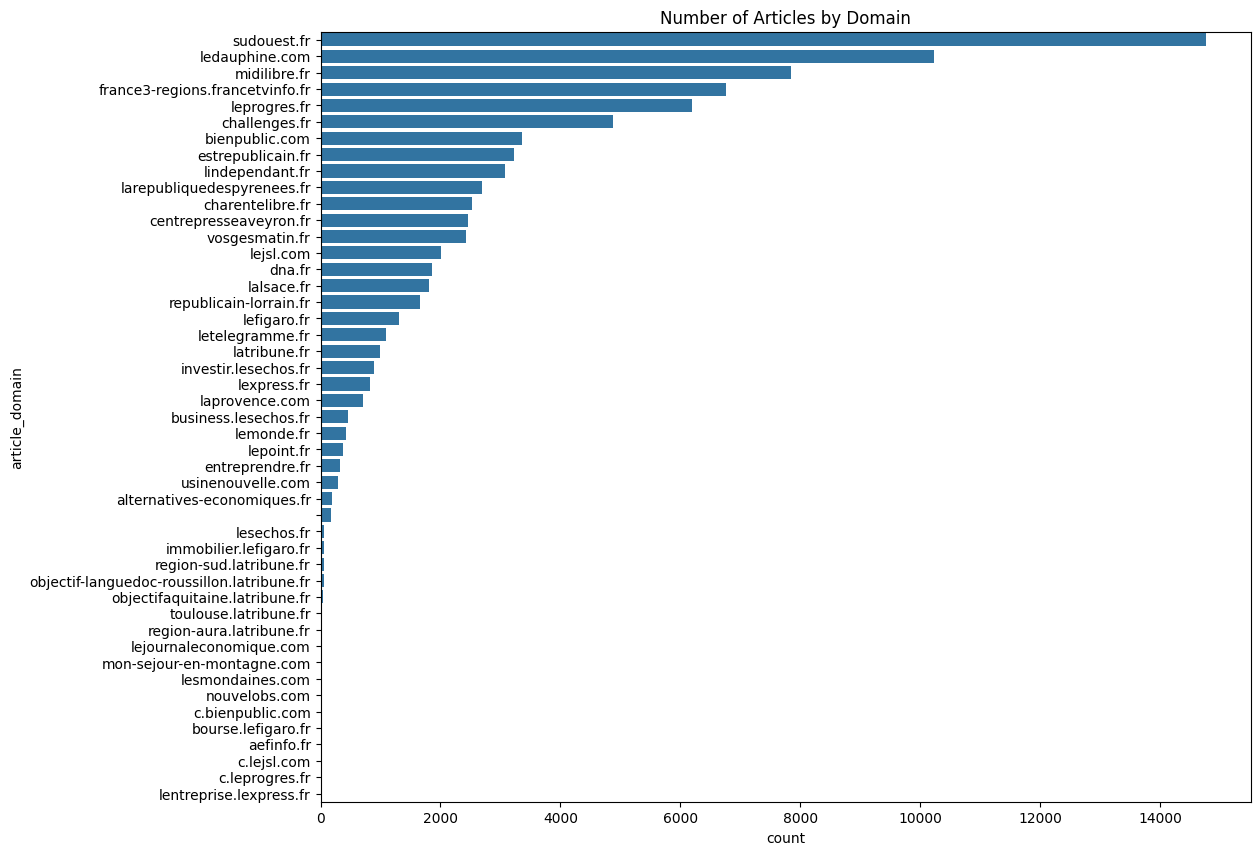

In [46]:
# Number of articles by domain

# Calculate counts
domain_counts = df["article_domain"].value_counts().reset_index()
domain_counts.columns = ['article_domain', 'count']

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(data=domain_counts, y="article_domain", x="count", orient='h')
plt.title("Number of Articles by Domain")
plt.show()

### Content Restrictions by Article Domain

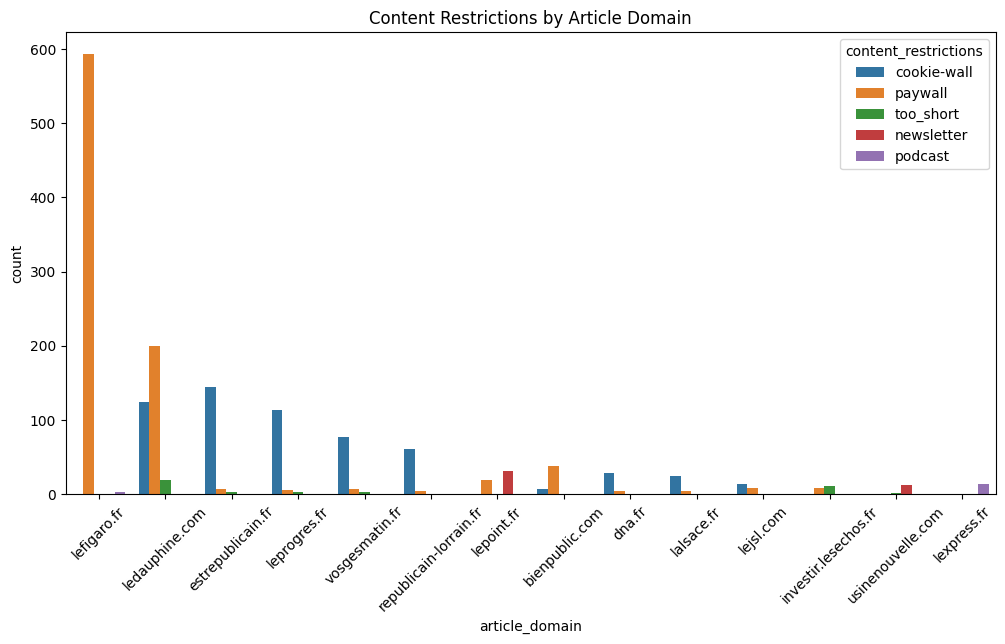

In [47]:
# Content restriction based on article source

restricted = df["content_restrictions"].notnull()

# Calculate counts
counts = df[restricted]["article_domain"].value_counts()

# Only keep counts > 10
counts = counts[counts > 10]

# Create order (sorted by counts)
order = counts.index

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df[restricted], x="article_domain", hue="content_restrictions", order=order)
plt.xticks(rotation=45)
plt.title("Content Restrictions by Article Domain")
plt.show()



# Word cloud

In [48]:
import nltk
from wordcloud import WordCloud
from wordcloud import STOPWORDS as STOPWORDS_WORDCLOUD

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
import requests
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-fr/master/stopwords-fr.txt"
github_french_stopwords = requests.get(stopwords_url).text.split()

In [50]:

from nltk.corpus import stopwords
french_stopwords = stopwords.words('french')
STOPWORDS = set(french_stopwords + ["a"] + list(STOPWORDS_WORDCLOUD) + github_french_stopwords)

## Title

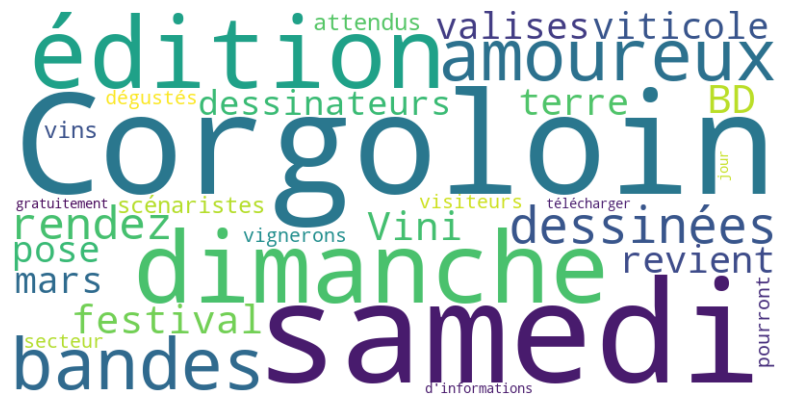

In [51]:
# concatenate all titles in a single string
titles = " ".join(df["title"].values)

wordcloud = WordCloud(width=800, height=400, 
                      background_color="white",
                      stopwords=STOPWORDS,
                      ).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text

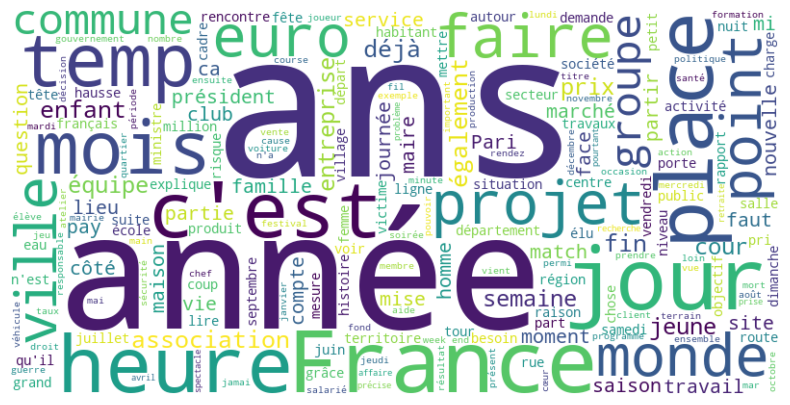

In [52]:
# find text with no restrictions (content_restrictions.isnull) and concatenate all the texts in a single string
text = " ".join(df[df["content_restrictions"].isnull()]["text"].values)

wordcloud = WordCloud(width=800, height=400, 
                      background_color="white",
                      stopwords=STOPWORDS,
                      ).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Date

In [53]:
min_date = df["date"].min()
max_date = df["date"].max()

print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

Min date: 2022-02-11 00:00:00
Max date: 2024-02-13 00:00:00


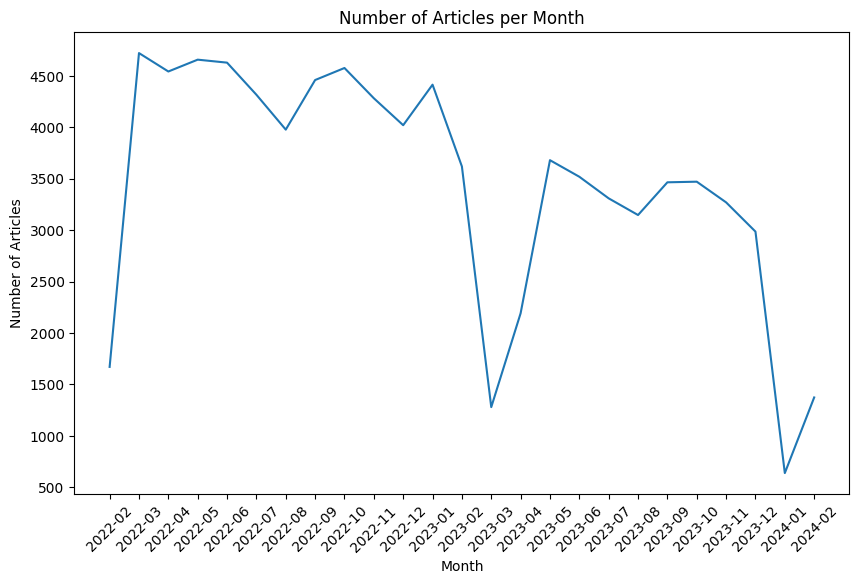

In [54]:
# Group by month and count the number of articles
monthly_counts = df.groupby(df['date'].dt.strftime('%Y-%m'))['date'].count()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts.index, monthly_counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Month')
plt.xticks(rotation=45)
plt.show()

# Exportation

In [57]:
from datetime import datetime

df['date_str'] = df['date'].dt.strftime('%Y-%m-%d')

FILE_NAME = f"newspapers_filtered_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.jsonl"
COLUMNS = ["title", "text",'date_str', "article_id", "article_url", "article_domain"]

filtered = df[df['content_restrictions'].isnull()][COLUMNS].rename(columns={'date_str': 'date'})

with open(FILE_NAME, "w", encoding="utf-8") as f:
    for item in filtered.to_dict(orient="records"):
        f.write(dumps(item, ensure_ascii=False) + "\n")

print(f"Saved {len(filtered)} rows in {FILE_NAME}")

Saved 84593 rows in newspapers_filtered_2024-04-30_18-17-52.jsonl
